In [16]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Epoch 1/50


C:\Users\vinay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


46/46 - 3s - 62ms/step - accuracy: 0.3053 - loss: 9.7611 - val_accuracy: 0.1163 - val_loss: 6.4376
Epoch 2/50
46/46 - 0s - 9ms/step - accuracy: 0.4094 - loss: 6.5298 - val_accuracy: 0.1551 - val_loss: 5.2124
Epoch 3/50
46/46 - 1s - 16ms/step - accuracy: 0.4858 - loss: 4.9877 - val_accuracy: 0.1717 - val_loss: 3.9862
Epoch 4/50
46/46 - 1s - 12ms/step - accuracy: 0.5441 - loss: 3.8380 - val_accuracy: 0.2299 - val_loss: 3.0648
Epoch 5/50
46/46 - 0s - 10ms/step - accuracy: 0.5940 - loss: 3.1324 - val_accuracy: 0.2355 - val_loss: 2.9246
Epoch 6/50
46/46 - 0s - 10ms/step - accuracy: 0.6301 - loss: 2.7437 - val_accuracy: 0.3102 - val_loss: 2.2597
Epoch 7/50
46/46 - 0s - 10ms/step - accuracy: 0.6440 - loss: 2.4371 - val_accuracy: 0.3380 - val_loss: 2.0470
Epoch 8/50
46/46 - 0s - 10ms/step - accuracy: 0.6815 - loss: 2.1154 - val_accuracy: 0.3269 - val_loss: 2.0704
Epoch 9/50
46/46 - 0s - 10ms/step - accuracy: 0.7099 - loss: 1.8541 - val_accuracy: 0.3712 - val_loss: 1.8163
Epoch 10/50
46/46 - 0s

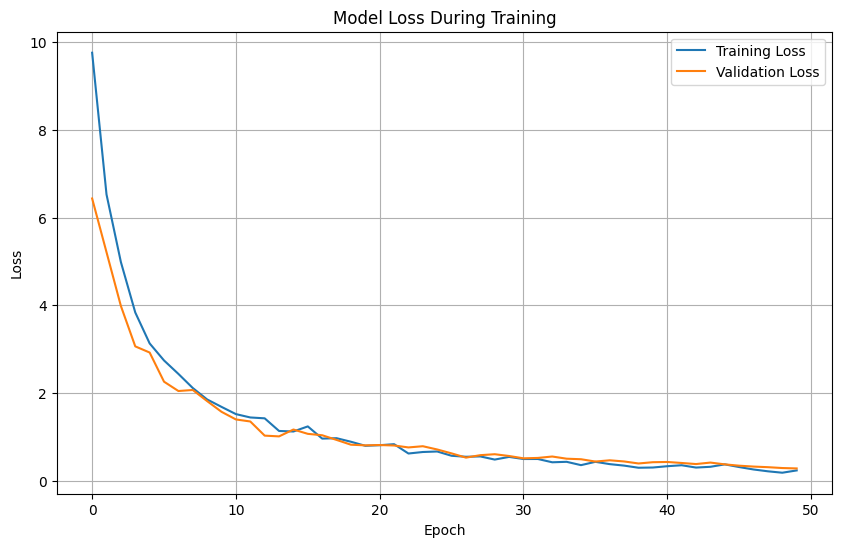

DNN Accuracy: 0.8510
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        34
           1       1.00      0.74      0.85        19
           2       0.83      0.94      0.88       109
           3       0.75      0.59      0.66        46

    accuracy                           0.85       208
   macro avg       0.89      0.81      0.84       208
weighted avg       0.85      0.85      0.85       208

Confusion Matrix:
[[ 34   0   0   0]
 [  1  14   2   2]
 [  0   0 102   7]
 [  0   0  19  27]]
Matthews Correlation Coefficient (MCC): 0.7642
Area Under the Curve (AUC): 0.9650


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, matthews_corrcoef
import joblib
import numpy as np
import matplotlib.pyplot as plt

def build_dnn_model(input_shape, num_classes):
    """
    Build Deep Neural Network model
    
    Parameters:
    input_shape (tuple): Shape of input features
    num_classes (int): Number of output classes
    
    Returns:
    keras.Model: Compiled DNN model
    """
    model_dnn = Sequential([
        Input(shape=(input_shape,)),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model_dnn.compile(
        optimizer=Adam(learning_rate=0.0001), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    return model_dnn

def plot_training_history(history):
    """
    Plot training and validation loss
    
    Parameters:
    history: keras.callbacks.History object
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# ------------------------ Load Data ------------------------
# Load gene data (replace file path with your own)
X_train_genes, X_test_genes, y_train_genes_cat, y_test_genes_cat, \
y_train_genes_int, y_test_genes_int, gene_label_encoder = joblib.load('500processed_gene_data.pkl')

# Build the DNN model
model_dnn = build_dnn_model(X_train_genes.shape[1], len(np.unique(y_train_genes_int)))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ------------------------ Train Model ------------------------
# Store the training history
history = model_dnn.fit(
    X_train_genes, y_train_genes_cat, 
    epochs=50, batch_size=32, 
    validation_split=0.2, 
    verbose=2, 
    callbacks=[early_stopping]
)

# Plot the training history
plot_training_history(history)

# ------------------------ Evaluate Model ------------------------
# Evaluate model on test data
accuracy_dnn = model_dnn.evaluate(X_test_genes, y_test_genes_cat, verbose=0)[1]
print(f"DNN Accuracy: {accuracy_dnn:.4f}")

# Predict classes and probabilities
y_pred_genes = model_dnn.predict(X_test_genes)  # Probabilities
y_pred_classes = np.argmax(y_pred_genes, axis=1)  # Predicted class indices
y_true_classes = np.argmax(y_test_genes_cat, axis=1)  # True class indices

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true_classes, y_pred_classes)

# Calculate AUC (One-vs-Rest strategy for multi-class)
auc = roc_auc_score(y_test_genes_cat, y_pred_genes, multi_class='ovr')

# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

# Print MCC and AUC
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc:.4f}")

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    matthews_corrcoef, 
    roc_auc_score, 
    confusion_matrix
)
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define improved CNN Model
class CNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(128 * (input_dim // 4), 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.bn1(self.relu(self.conv1(x))))
        x = self.pool(self.bn2(self.relu(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)

def train_and_evaluate():
    # Load Preprocessed Data
    data_path = '0.95processed_image_data.pkl'
    X_train_images, X_test_images, y_train_images, y_test_images, image_label_encoder = joblib.load(data_path)
    
    # Apply SMOTE for class balancing
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_images, y_train_images)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_balanced = scaler.fit_transform(X_train_balanced)
    X_test_images = scaler.transform(X_test_images)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_balanced, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train_balanced, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_images, dtype=torch.float32).unsqueeze(1)
    
    # Model parameters
    input_dim = X_train_balanced.shape[1]
    output_dim = len(np.unique(y_train_balanced))
    
    # Calculate class weights
    class_counts = np.bincount(y_train_balanced)
    class_weights = torch.tensor(
        [len(y_train_balanced) / (len(class_counts) * count) for count in class_counts],
        dtype=torch.float32
    )
    
    # Initialize model, loss, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    cnn_model = CNN(input_dim=input_dim, output_dim=output_dim).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
    # Training parameters
    num_epochs = 100
    batch_size = 64
    train_losses = []
    
    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Training loop
    print("Starting training...")
    for epoch in range(num_epochs):
        cnn_model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)
        scheduler.step(avg_epoch_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('training_loss.png')
    plt.close()
    
    # Evaluation
    print("\nEvaluating model...")
    cnn_model.eval()
    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        pred_cnn_probs = cnn_model(X_test_tensor).cpu().numpy()
    
    pred_cnn = np.argmax(pred_cnn_probs, axis=1)
    
    # Print metrics
    accuracy_cnn = accuracy_score(y_test_images, pred_cnn)
    print(f"\nCNN Accuracy: {accuracy_cnn:.4f}")
    
    conf_matrix = confusion_matrix(y_test_images, pred_cnn)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    print("\nClassification Report:")
    print(classification_report(y_test_images, pred_cnn))
    
    mcc = matthews_corrcoef(y_test_images, pred_cnn)
    print(f"\nMatthews Correlation Coefficient (MCC): {mcc:.4f}")
    
    try:
        auc_score = roc_auc_score(
            np.eye(output_dim)[y_test_images],
            pred_cnn_probs,
            multi_class='ovr'
        )
        print(f"\nAUC-ROC Score: {auc_score:.4f}")
    except ValueError:
        print("\nAUC-ROC Score could not be calculated due to a single class in labels.")
    
    # Save the model
    torch.save({
        'model_state_dict': cnn_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler': scaler,
        'class_weights': class_weights,
        'input_dim': input_dim,
        'output_dim': output_dim
    }, 'cnn_model.pth')
    
    return cnn_model, scaler

if __name__ == "__main__":
    model, scaler = train_and_evaluate()

C:\Users\vinay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\vinay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cpu
Starting training...


Epoch 10/100: 100%|███████████████████████████████████████████████████████| 21/21 [00:01<00:00, 18.01it/s, loss=0.1748]


Epoch [10/100], Loss: 0.1584


Epoch 20/100: 100%|███████████████████████████████████████████████████████| 21/21 [00:01<00:00, 18.78it/s, loss=0.0345]


Epoch [20/100], Loss: 0.0338


Epoch 30/100: 100%|███████████████████████████████████████████████████████| 21/21 [00:01<00:00, 17.32it/s, loss=0.0117]


Epoch [30/100], Loss: 0.0131


Epoch 40/100: 100%|███████████████████████████████████████████████████████| 21/21 [00:01<00:00, 18.09it/s, loss=0.0051]


Epoch [40/100], Loss: 0.0070


Epoch 50/100: 100%|███████████████████████████████████████████████████████| 21/21 [00:01<00:00, 17.66it/s, loss=0.0042]


Epoch [50/100], Loss: 0.0042


Epoch 60/100: 100%|███████████████████████████████████████████████████████| 21/21 [00:01<00:00, 20.28it/s, loss=0.0018]


Epoch [60/100], Loss: 0.0028


Epoch 70/100: 100%|███████████████████████████████████████████████████████| 21/21 [00:01<00:00, 17.93it/s, loss=0.0020]


Epoch [70/100], Loss: 0.0019


Epoch 80/100: 100%|███████████████████████████████████████████████████████| 21/21 [00:01<00:00, 16.88it/s, loss=0.0021]


Epoch [80/100], Loss: 0.0017


Epoch 90/100: 100%|███████████████████████████████████████████████████████| 21/21 [00:01<00:00, 18.26it/s, loss=0.0018]


Epoch [90/100], Loss: 0.0016


Epoch 100/100: 100%|██████████████████████████████████████████████████████| 21/21 [00:01<00:00, 18.16it/s, loss=0.0012]


Epoch [100/100], Loss: 0.0015

Evaluating model...

CNN Accuracy: 0.5475

Confusion Matrix:
[[20  2  6  6]
 [ 5  2 10  1]
 [ 7  0 66 15]
 [ 6  2 21 10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.59      0.56        34
           1       0.33      0.11      0.17        18
           2       0.64      0.75      0.69        88
           3       0.31      0.26      0.28        39

    accuracy                           0.55       179
   macro avg       0.45      0.43      0.42       179
weighted avg       0.52      0.55      0.52       179


Matthews Correlation Coefficient (MCC): 0.2904

AUC-ROC Score: 0.6733


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fusion Model Accuracy: 0.8324

Classification Report for Fusion Model:
              precision    recall  f1-score   support

  BRCA_Basal       0.97      1.00      0.98        28
   BRCA_Her2       1.00      0.72      0.84        18
   BRCA_LumA       0.81      0.93      0.87        94
   BRCA_LumB       0.70      0.54      0.61        39

    accuracy                           0.83       179
   macro avg       0.87      0.80      0.82       179
weighted avg       0.83      0.83      0.83       179



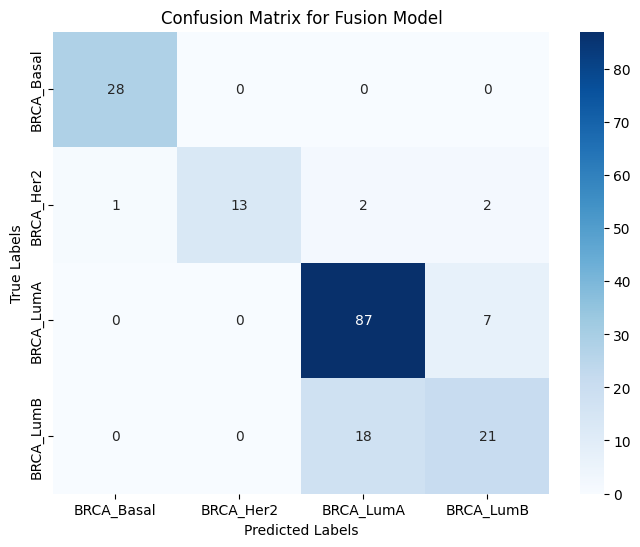

Fusion Model MCC: 0.7343
Fusion Model AUC: 0.9555


In [10]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    matthews_corrcoef,
)
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the CNN model is in evaluation mode
cnn_model.eval()

# Generate predictions from the CNN model
with torch.no_grad():
    pred_cnn_probs = cnn_model(
        torch.tensor(X_test_images, dtype=torch.float32).unsqueeze(1)
    ).numpy()  # Convert PyTorch tensor to NumPy array

# Generate predictions from the DNN model
pred_dnn_probs = model_dnn.predict(X_test_genes)

# Align predictions and test labels
min_samples = min(pred_dnn_probs.shape[0], pred_cnn_probs.shape[0])
pred_dnn_aligned = pred_dnn_probs[:min_samples]
pred_cnn_aligned = pred_cnn_probs[:min_samples]
y_test_aligned = y_test_genes_cat[:min_samples]  # Assuming one-hot encoded labels

# Fusion of DNN and CNN outputs
alpha, beta = 0.88185, 0.11815
fused_predictions = alpha * pred_dnn_aligned + beta * pred_cnn_aligned

# Final predicted classes
final_predictions = np.argmax(fused_predictions, axis=1)
true_labels = np.argmax(y_test_aligned, axis=1)

# Fusion Model Evaluation
accuracy_fusion = accuracy_score(true_labels, final_predictions)
print(f"Fusion Model Accuracy: {accuracy_fusion:.4f}")

# Classification Report
print("\nClassification Report for Fusion Model:")
print(
    classification_report(
        true_labels,
        final_predictions,
        target_names=gene_label_encoder.classes_,
    )
)

# Confusion Matrix
conf_matrix_fusion = confusion_matrix(true_labels, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_fusion,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=gene_label_encoder.classes_,
    yticklabels=gene_label_encoder.classes_,
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Fusion Model')
plt.show()

# Matthews Correlation Coefficient
mcc_fusion = matthews_corrcoef(true_labels, final_predictions)
print(f"Fusion Model MCC: {mcc_fusion:.4f}")

# AUC for Fusion Model
try:
    auc_fusion = roc_auc_score(
        y_test_aligned, fused_predictions, multi_class='ovr', average='weighted'
    )
    print(f"Fusion Model AUC: {auc_fusion:.4f}")
except ValueError as e:
    print(f"AUC calculation error for Fusion Model: {e}")
